In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset
import pmdarima as pm
from prophet import Prophet

# Dataset

In [2]:
revenue = pd.read_csv('Datasets/revenue_time_series.csv')
revenue['InvoiceDate'] = pd.to_datetime(revenue['InvoiceDate']).dt.strftime('%Y-%m-%d')
revenue['InvoiceDate'] = pd.to_datetime(revenue['InvoiceDate'])

temp = pd.read_csv('Datasets/temp.csv')
temp['datetime'] = pd.to_datetime(temp['datetime'])

holidays = pd.read_csv('Datasets/en.uk holiday.csv',header=None)
holidays = holidays.rename(columns={0: "date", 1: "holiday"})
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays[(holidays['date']>='2010-12-01') & (holidays['date']<='2011-12-09')]

In [3]:
revenue = revenue.groupby('InvoiceDate')['Revenue'].sum().reset_index()

In [4]:
df = revenue.merge(temp,how='left', left_on='InvoiceDate',right_on='datetime')
df = df.merge(holidays,how='left', left_on='InvoiceDate',right_on='date')
df = df.drop(columns=['date','datetime'])
df.loc[df['holiday'].isna(),'holiday'] = 'Non-holiday'
df = df.set_index('InvoiceDate').sort_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 305 entries, 2010-12-01 to 2011-12-09
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  305 non-null    float64
 1   temp     305 non-null    float64
 2   holiday  305 non-null    object 
dtypes: float64(2), object(1)
memory usage: 9.5+ KB


None

<Axes: xlabel='InvoiceDate'>

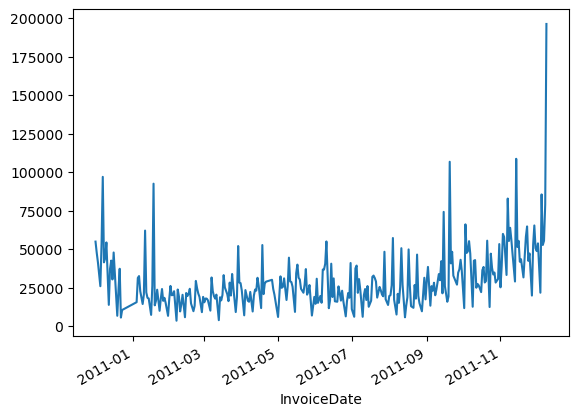

In [5]:
display(df.info())
df['Revenue'].plot()

<Axes: xlabel='InvoiceDate'>

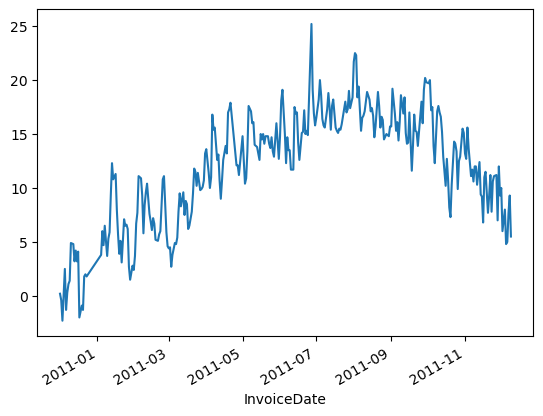

In [6]:
df['temp'].plot()

In [7]:
q1 = df['Revenue'].quantile(.001)
q3 = df['Revenue'].quantile(1-.001)
df2 = df[(df['Revenue']>=q1) & (df['Revenue']<=q3)]

In [8]:
from sklearn.preprocessing import OneHotEncoder
df3 = df2.copy()
df3['holiday'] = df3['holiday'].astype('category')
df3['holiday_new'] = df3['holiday'].cat.codes
df3.select_dtypes(exclude='category').corr()

,Revenue,temp,holiday_new
Revenue,1.000000,-0.078936,0.017348
temp,-0.078936,1.000000,-0.078351
holiday_new,0.017348,-0.078351,1.000000


# Check Stationary

<Axes: xlabel='InvoiceDate'>

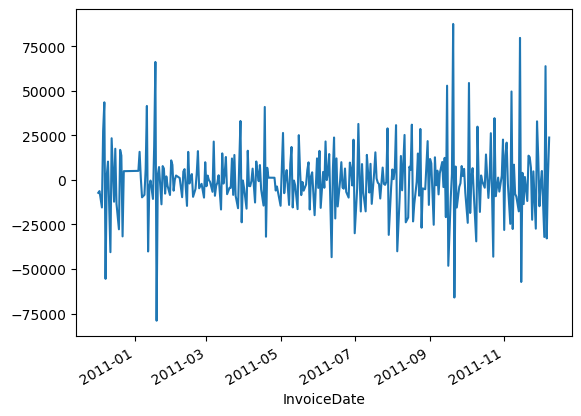

In [9]:
df_s = df2['Revenue'].diff().dropna()
df_s.plot()

In [10]:
adfuller(df_s)

(-7.678749107346882,
 1.5238144443620454e-11,
 10,
 291,
 {'1%': -3.4530232710482367,
  '5%': -2.871523926671883,
  '10%': -2.5720897694878424},
 6228.917435980627)

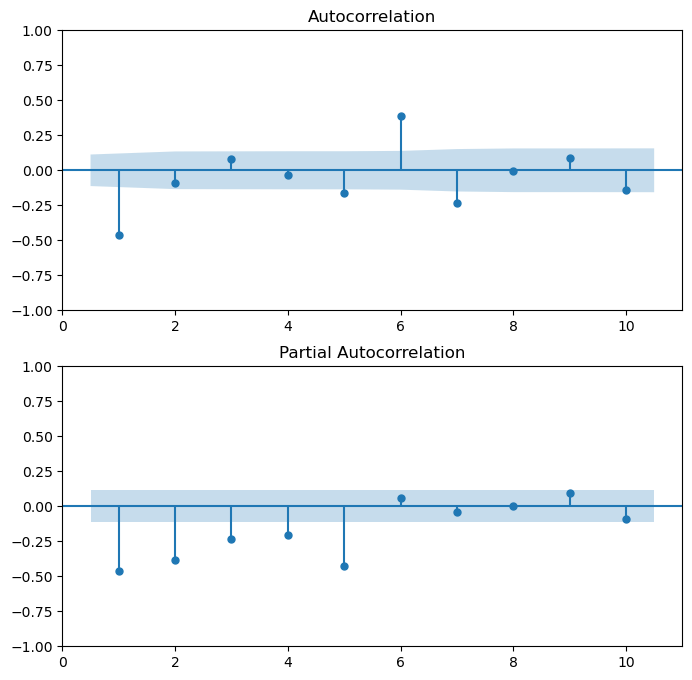

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(df_s, lags=10, zero=False, ax=ax1)
plot_pacf(df_s, lags=10, zero=False, ax=ax2)
plt.show()

In [12]:
order_aic_bic =[]
for p in range(11):
    for q in range(11):
        model = ARIMA(df2['Revenue'], order=(p,1,q),exog=df2['temp'])
        results = model.fit()
        order_aic_bic.append((p, q, results.aic, results.bic))
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:

In [13]:
print(order_df.sort_values('aic').head())

    p   q          aic          bic
85  7   8  6623.132590  6686.209849
97  8   9  6623.644891  6694.143004
54  4  10  6625.531488  6684.898320
86  7   9  6626.102808  6692.890494
96  8   8  6626.154067  6692.941753


# Model Building

In [14]:
model = ARIMA(df2['Revenue'], order=(7,1,8))
results = model.fit()
print(results.summary())

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  303
Model:                 ARIMA(7, 1, 8)   Log Likelihood               -3296.651
Date:                Wed, 24 Apr 2024   AIC                           6625.302
Time:                        00:29:22   BIC                           6684.669
Sample:                             0   HQIC                          6649.055
                                - 303                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6767      0.243     -2.790      0.005      -1.152      -0.201
ar.L2          0.0450      0.374      0.120      0.904      -0.689       0.779
ar.L3          0.2352      0.330      0.712      0.4

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9780.882684143799


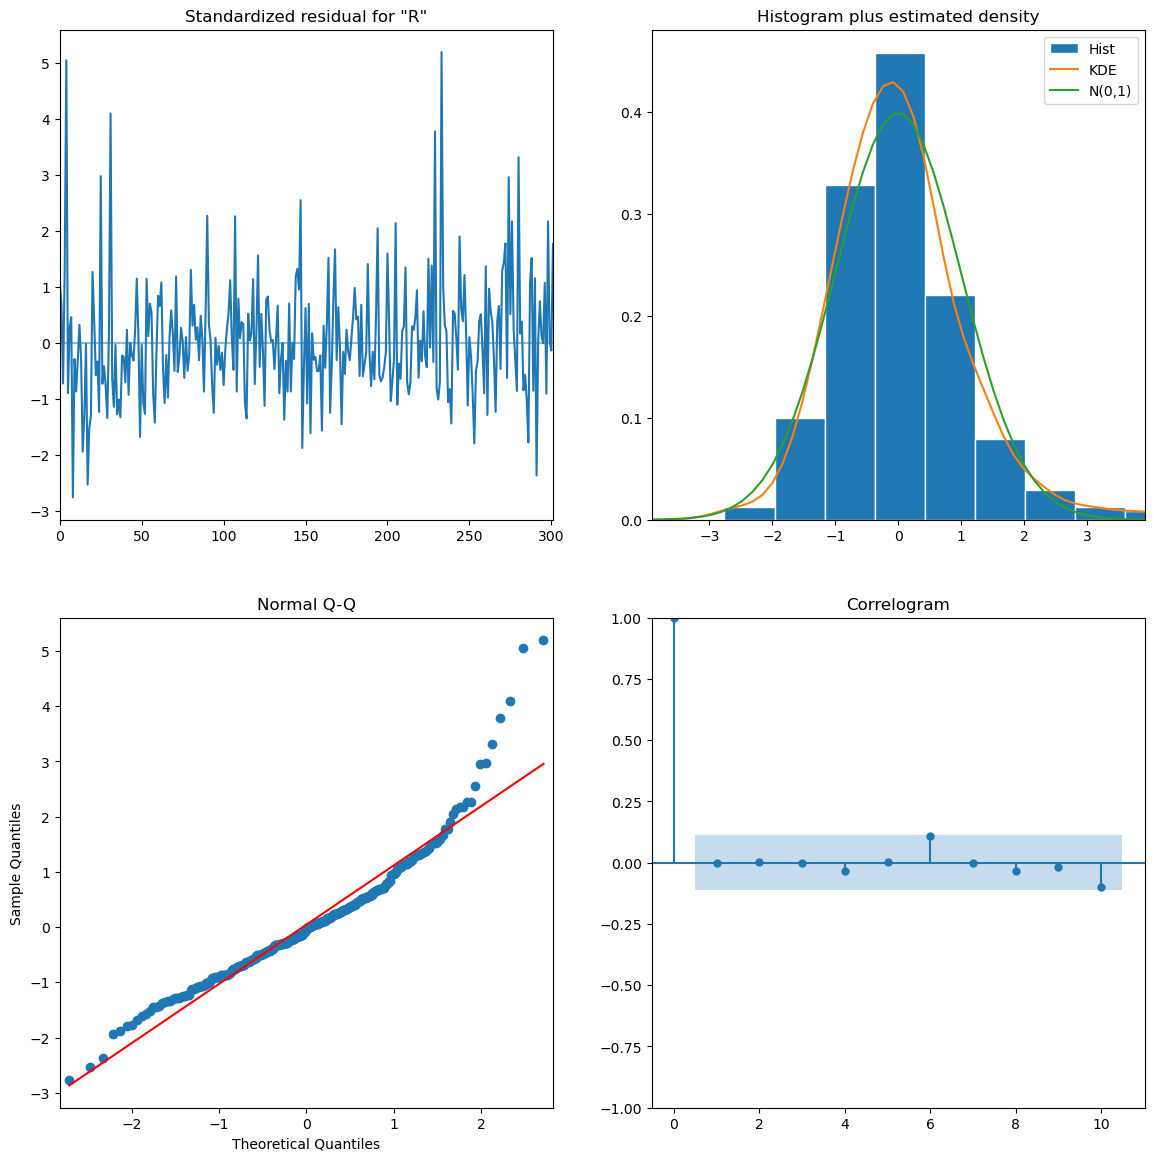

In [15]:
print(np.mean(np.abs(results.resid)))
results.plot_diagnostics(figsize=(14,14))
plt.show()

# Forcasting

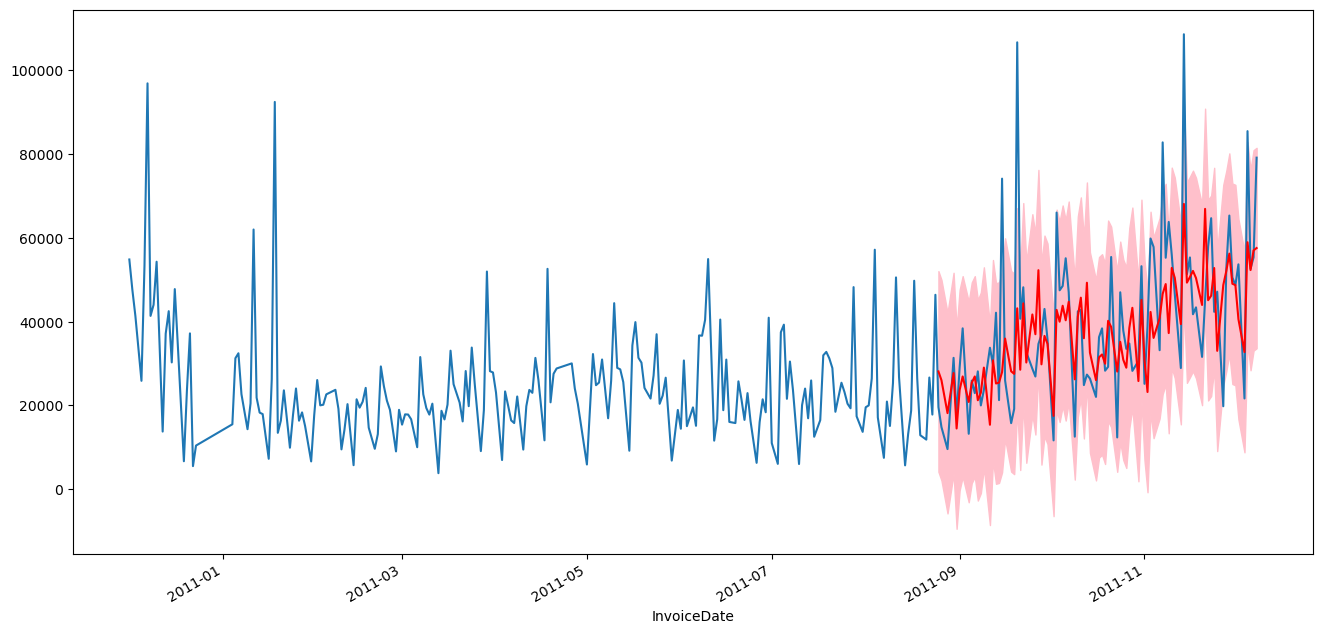

In [16]:
forecast = results.get_prediction(start=-90)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
plt.figure(figsize=(16,8))
df2['Revenue'].plot()
plt.plot(mean_forecast.index,mean_forecast.values,color='red',label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'],
                  confidence_intervals['upper Revenue'], color='pink')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


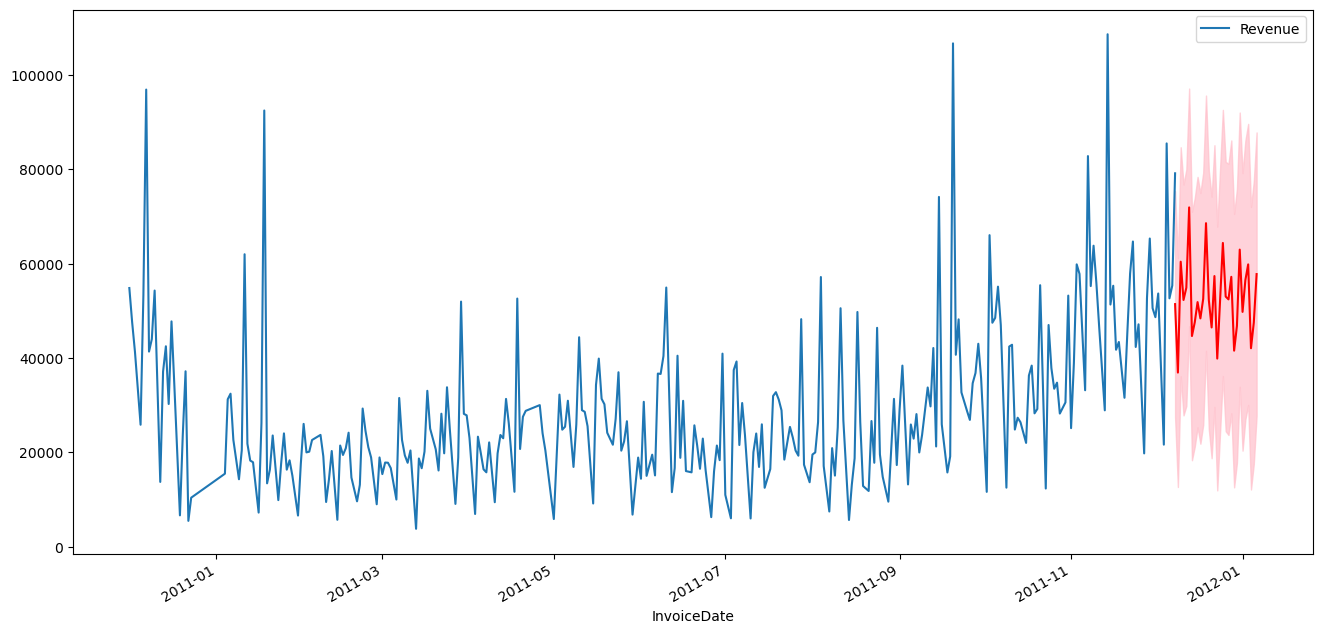

In [17]:
days = 30  #days to predict
future_dates = [df2.index[-1]+ DateOffset(days=x)for x in range(0,days)]
forecast_result = results.get_forecast(steps=days)
forecast_result_mean = forecast_result.predicted_mean
forecast_result_interval = forecast_result.conf_int()

plt.figure(figsize=(16,8))
df2['Revenue'].plot()
sns.lineplot(x=future_dates,y=forecast_result_mean.values,color='r')
plt.fill_between(future_dates, forecast_result_interval['lower Revenue'],
                  forecast_result_interval['upper Revenue'], alpha=0.7, color="pink")
plt.show()


# Seasonal

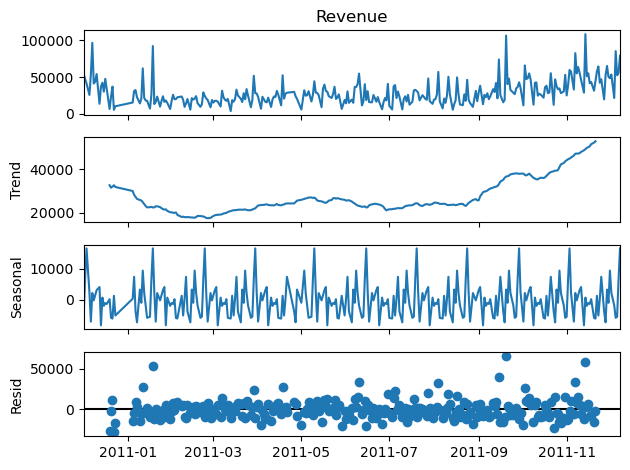

In [18]:
decomp_results = seasonal_decompose(df2['Revenue'], period=30)
decomp_results.plot()
plt.show()

In [19]:
df_diff = df2['Revenue'].diff(30)

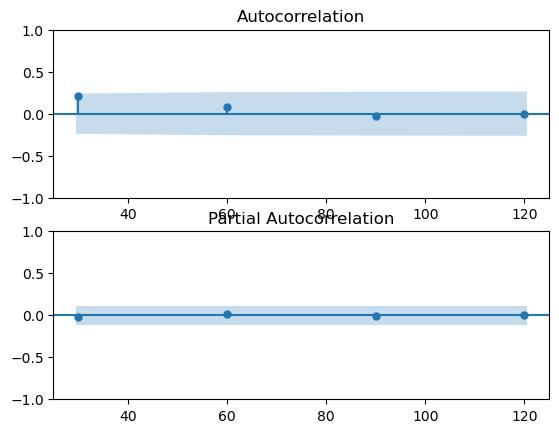

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1)
plot_acf(df2['Revenue'], lags=[30,60,90,120], ax=ax1)
plot_pacf(df2['Revenue'], lags=[30,60,90,120], ax=ax2)
plt.show()

In [21]:
results = pm.auto_arima( df2['Revenue'],
d=1,
start_p=1,
start_q=1,
max_p=10,
max_q=10,
seasonal=True,
m=30,
information_criterion='aic',
trace=True,
error_action='ignore',
stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[30] intercept   : AIC=6661.652, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=6831.274, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=6753.880, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=6655.005, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=6829.281, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=6658.035, Time=0.04 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=6659.881, Time=0.77 sec
 ARIMA(0,1,1)(0,0,2)[30] intercept   : AIC=6654.592, Time=3.57 sec
 ARIMA(0,1,1)(1,0,2)[30] intercept   : AIC=inf, Time=3.56 sec
 ARIMA(0,1,0)(0,0,2)[30] intercept   : AIC=6827.767, Time=1.21 sec
 ARIMA(1,1,1)(0,0,2)[30] intercept   : AIC=6658.891, Time=2.69 sec
 ARIMA(0,1,2)(0,0,2)[30] intercept   : AIC=6652.365, Time=2.86 sec
 ARIMA(0,1,2)(0,0,1)[30] intercept   : AIC=6653.610, Time=0.94 sec
 ARIMA(0,1,2)(1,0,2)[30] intercept   : AIC=6654.339, Time=3.87 sec
 ARIMA(0,1,2)(1,0,1)[30]

In [22]:
model_seasonal = SARIMAX(df2['Revenue'], order=(1,1,3), seasonal_order=(2,0,0,30))
results_seasonal = model.fit()

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


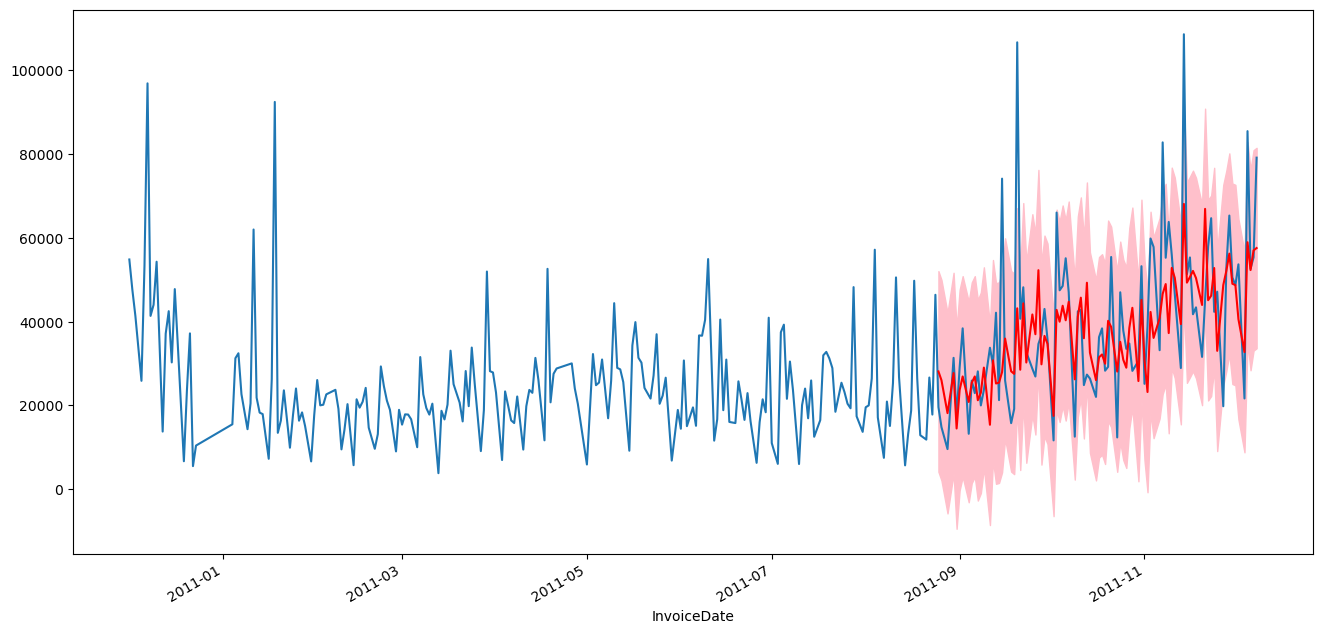

In [23]:
forecast = results_seasonal.get_prediction(start=-90)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
plt.figure(figsize=(16,8))
df2['Revenue'].plot()
plt.plot(mean_forecast.index,mean_forecast.values,color='red',label='forecast')
plt.fill_between(confidence_intervals.index, confidence_intervals['lower Revenue'],
                  confidence_intervals['upper Revenue'], color='pink')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/Caskroom/miniforge/base/envs/py_projects/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


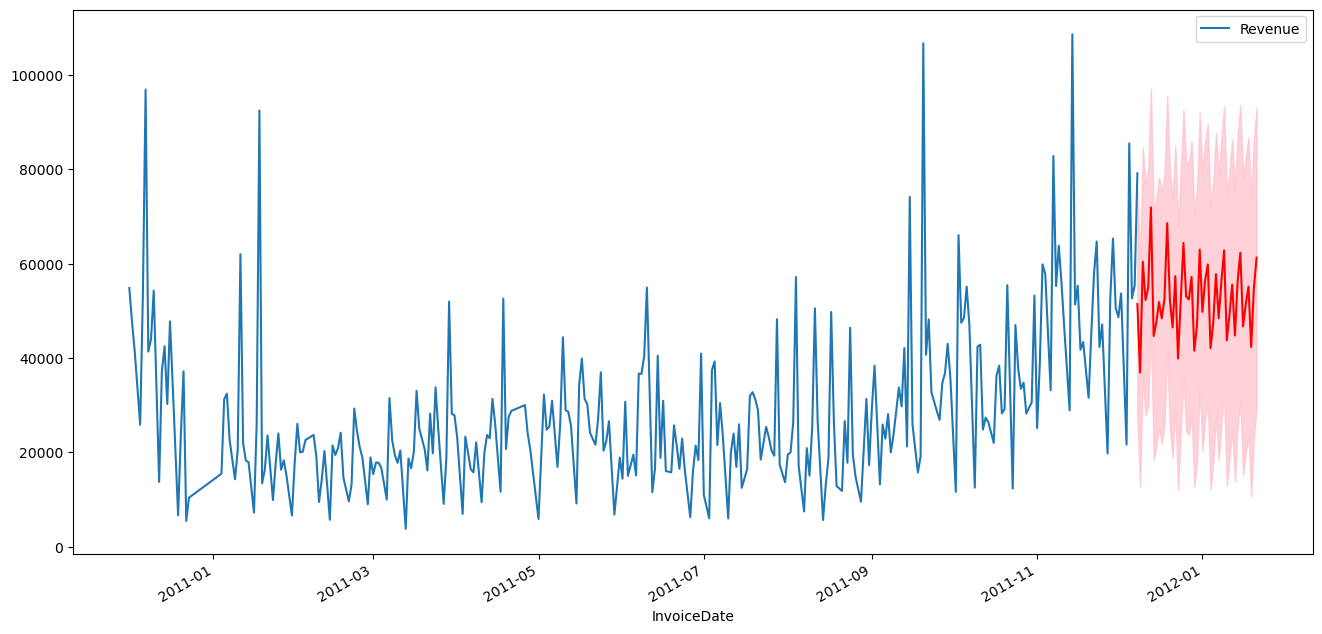

In [24]:
days = 45  #days to predict
future_dates = [df2.index[-1]+ DateOffset(days=x)for x in range(0,days)]
forecast_result = results_seasonal.get_forecast(steps=days)
forecast_result_mean = forecast_result.predicted_mean
forecast_result_interval = forecast_result.conf_int()

plt.figure(figsize=(16,8))
df2['Revenue'].plot()
sns.lineplot(x=future_dates,y=forecast_result_mean.values,color='r')
plt.fill_between(future_dates, forecast_result_interval['lower Revenue'],
                  forecast_result_interval['upper Revenue'], alpha=0.7, color="pink")
plt.show()


# Prophet Model

In [25]:
df3 = df2['Revenue'].reset_index().rename(columns=
                        {"InvoiceDate": "ds", "Revenue": "y"})
df3.head()

,ds,y
0,2010-12-01,54818.08
1,2010-12-02,47570.53
2,2010-12-03,41308.69
3,2010-12-05,25853.20
4,2010-12-06,53322.12


In [26]:
model = Prophet()
model.fit(df3)

00:30:42 - cmdstanpy - INFO - Chain [1] start processing
00:30:42 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = model.make_future_dataframe(periods=30)
forecast_p = model.predict(future)
forecast_p2 = forecast_p[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

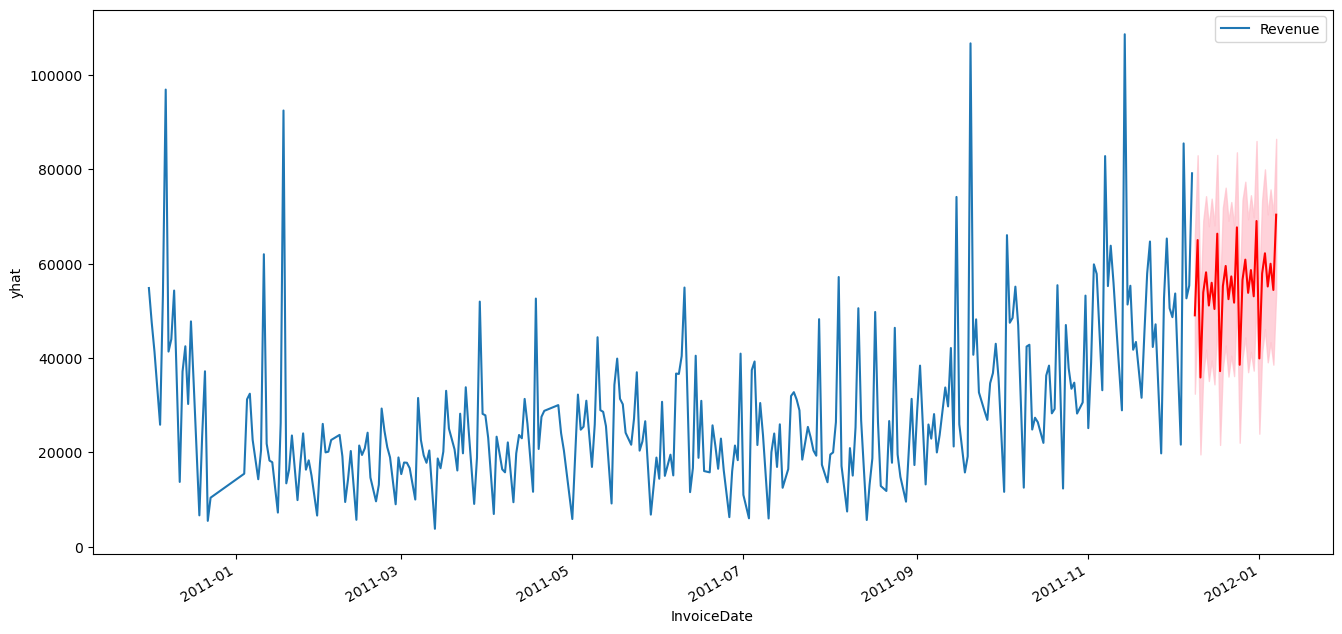

In [28]:
plt.figure(figsize=(16,8))
df2['Revenue'].plot()
sns.lineplot(x=forecast_p2['ds'],y=forecast_p2['yhat'],color='r')
plt.fill_between(forecast_p2['ds'], forecast_p2['yhat_lower'],
                  forecast_p2['yhat_upper'], alpha=0.7, color="pink")
plt.show()